In [93]:
import os
from PIL import Image, ImageDraw, ImageFont
import tqdm

In [94]:
dir_path = r'C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images'
image_list = [f for f in os.listdir(dir_path) if f.endswith(('.jpg', '.png', '.jpeg', 'JPG', 'PNG', 'JPEG'))]
label_list = ()
num_zeroDection = 0
for image in image_list:
    label_dir_poss = (os.path.splitext(image)[0] + '.txt')
    label_dir = os.path.join(dir_path, label_dir_poss)
    if not os.path.exists(label_dir):
        print('label file not exist: ', image)
        num_zeroDection += 1
        continue
    label_list += (label_dir,)
print('num_zeroDection: ', num_zeroDection)
print('label_list has ', len(label_list), ' elements')
print('image_list has ', len(image_list), ' elements')


num_zeroDection:  0
label_list has  163  elements
image_list has  163  elements


In [95]:
def readText(path):
    AnnotationDict = {}
    with open(path, 'r') as f:
        lines = f.read()
    for i,line in enumerate(lines.split('\n')):
        if line:
            line = line.split(' ')
            if len(line) == 5:                          #for rectangle, category:str, x:float, y, w, h of the annotation
                category = int(line[0])
                x = float(line[1])
                y = float(line[2])
                w = float(line[3])
                h = float(line[4])
                AnnotationDict[i] = [category, x, y, w, h]
            elif len(line) == 6:                         #for oriented box and ellipse, category:str, x:float, y, w, h, theta:int of the annotation
                category = int(line[0])
                x = float(line[1])
                y = float(line[2])
                w = float(line[3])
                h = float(line[4])
                theta = int(line[5])
                AnnotationDict[i] = [category, x, y, w, h, theta]
            elif len(line) >= 9 and len(line) % 2 == 1:                 #for multi-side polygon, category:str, x1:float, y1, x2, y2, x3, y3, ... of the annotation
                category = int(line[0])
                AnnotationDict[i] = [category]
                AnnotationDict[i].extend([float(x) for x in line[1:]])
    # print(f'processing {path}, got {len(AnnotationDict)} annotations')
    return AnnotationDict


{0: [3, 0.659, 0.062, 0.784, 0.097, 0.816, 0.15, 0.679, 0.1], 1: [5, 0.694, 0.44, 0.709, 0.44, 0.711, 0.452, 0.696, 0.452]}


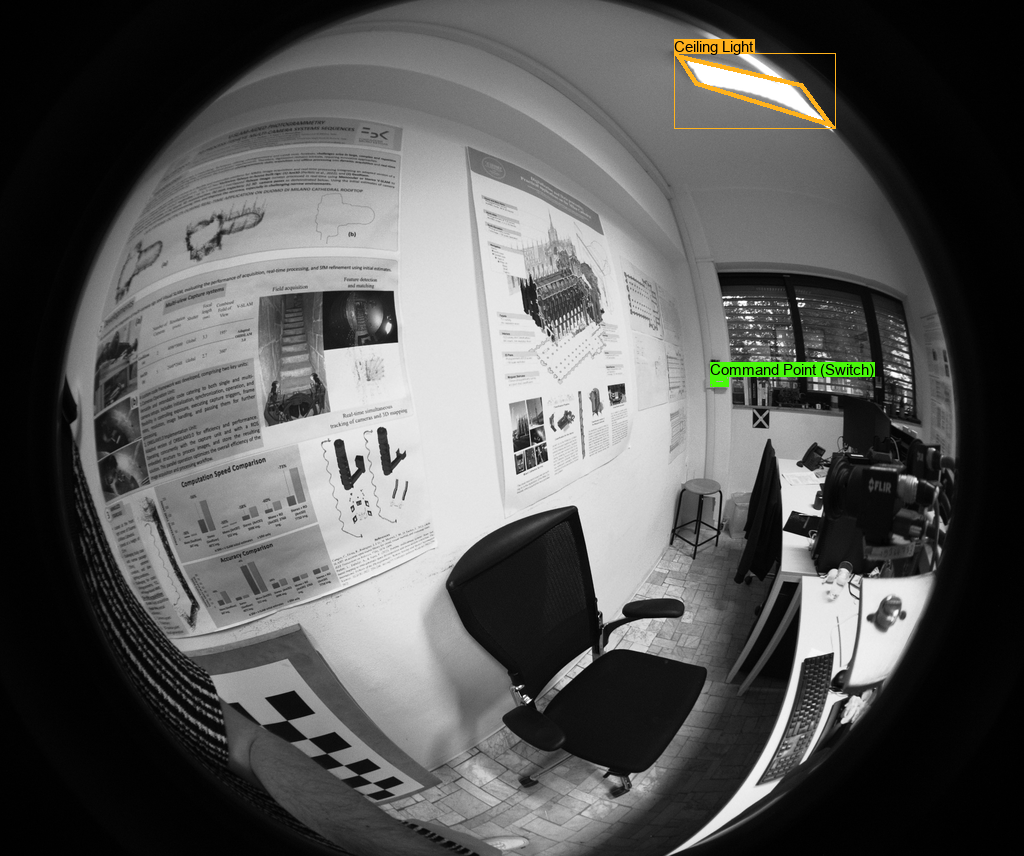

In [96]:
colorIndex = ('#FF3838', '#FF9D97', '#FF701F', '#FFB21D', '#CFD231', '#48F90A', '#92CC17', '#3DDB86', '#1A9334', '#00D4BB',
              '#2C99A8', '#00C2FF', '#344593', '#6473FF', '#0018EC', '#8438FF', '#520085', '#CB38FF', '#FF95C8', '#FF37C7')
categoryIndex = ('Smoke Detector','Alarm Button','Fire Extinguisher', 'Ceiling Light',
                 'FM Power Point (Plug)', 'Command Point (Switch)','Security Cameras')
def annotateImage(image, annotation, colorIndex=colorIndex, categoryIndex=categoryIndex, resize=True):
    w,h = image.size
    image_anno = image.copy()
    if resize:
        ratio = 1024 / max(w, h)
        w = int(w * ratio)
        h = int(h * ratio)
        image_anno = image_anno.resize((w, h), Image.Resampling.LANCZOS)
        
    draw = ImageDraw.Draw(image_anno)
    for key in annotation:
        category = annotation[key][0]
        color = colorIndex[category % len(colorIndex)]

        if len(annotation[key]) == 5:
            x = annotation[key][1] * w
            y = annotation[key][2] * h
            w_box = annotation[key][3] * w
            h_box = annotation[key][4] * h
            xmin = x - w_box // 2
            ymin = y - h_box // 2
            xmax = x + w_box // 2
            ymax = y + h_box // 2
            draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=5)
            pass
        
        elif len(annotation[key]) == 6:
            pass

        elif len(annotation[key]) >= 9 and len(annotation[key]) % 2 == 1:
            point = []
            box = []
            for i in range(1, len(annotation[key]), 2):
                x = int(annotation[key][i] * w)
                y = int(annotation[key][i+1] * h)
                point.extend([x, y])
            xmin = min(point[::2])
            ymin = min(point[1::2])
            xmax = max(point[::2])
            ymax = max(point[1::2])
            box = [xmin, ymin, xmax, ymax]
            draw.rectangle(box, outline=color, width=1)
            draw.polygon(point, outline=color, width=5)
        # print('category: ', category)
        # print(xmin, ymin, xmax, ymax)
        fontsize = 15
        x_text = xmin
        y_text = ymin-fontsize if ymin > fontsize else ymin
        text = categoryIndex[category]
        
        font = ImageFont.truetype("arial.ttf", fontsize)
        text_bbox = draw.textbbox((x_text, y_text-2), text, font=font)
        text_background = [text_bbox[0], text_bbox[1], text_bbox[2], text_bbox[3]]
        draw.rectangle(text_background, fill=color)
        draw.text((x_text, y_text), text, fill="black", font=font)
    return image_anno

dict_temp = readText(label_list[0])
print(dict_temp)
image = Image.open(os.path.join(dir_path, image_list[0]))
image = image.convert('RGB')
image_anno = annotateImage(image, dict_temp)
image_anno 

In [106]:
output_dir = os.path.join(dir_path, 'output')
os.makedirs(output_dir, exist_ok=True)
print(output_dir)
for i in tqdm.tqdm(range(len(label_list)), desc="Processing images"):
    image_dir_poss = os.path.splitext(label_list[i])[0] + '.jpg'
    image = Image.open(os.path.join(dir_path, image_dir_poss))
    image = image.convert('RGB')
    dict_temp = readText(label_list[i])
    image_anno = annotateImage(image, dict_temp)
    dir_imageoutput = os.path.join(output_dir, os.path.basename(image_dir_poss))
    print(dir_imageoutput)
    image_anno.save(dir_imageoutput)
    print(f'saving {label_list[i]} to {output_dir}')

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:   1%|          | 2/163 [00:00<00:14, 11.47it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067146.700348825_frame20_8539.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067146.700348825_frame20_8539.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067158.842361942_frame136_8655.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067158.842361942_frame136_8655.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:   2%|▏         | 4/163 [00:00<00:17,  9.25it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067160.927001095_frame156_8675.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067160.927001095_frame156_8675.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067173.387330865_frame273_8792.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067173.387330865_frame273_8792.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:   4%|▎         | 6/163 [00:00<00:21,  7.44it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067177.264983624_frame309_8828.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067177.264983624_frame309_8828.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067177.621407780_frame312_8831.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067177.621407780_frame312_8831.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:   5%|▍         | 8/163 [00:01<00:21,  7.05it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067180.17151919_frame335_8854.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067180.17151919_frame335_8854.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067186.641922237_frame401_8920.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067186.641922237_frame401_8920.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:   6%|▌         | 10/163 [00:01<00:19,  7.72it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067187.312229382_frame408_8927.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067187.312229382_frame408_8927.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067188.18922148_frame415_8934.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067188.18922148_frame415_8934.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:   7%|▋         | 11/163 [00:01<00:18,  8.12it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067188.947587273_frame424_8943.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067188.947587273_frame424_8943.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067193.675043807_frame473_8992.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067193.675043807_frame473_8992.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067196.301723248_frame501_9020.jpg


Processing images:   8%|▊         | 13/163 [00:01<00:15,  9.40it/s]

saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067196.301723248_frame501_9020.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067198.100264276_frame521_9040.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067198.100264276_frame521_9040.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067203.313695905_frame577_9096.jpg


Processing images:  11%|█         | 18/163 [00:01<00:10, 13.61it/s]

saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067203.313695905_frame577_9096.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067208.244901375_frame629_9148.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067208.244901375_frame629_9148.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067211.125101489_frame656_9175.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067211.125101489_frame656_9175.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067214.350390500_frame684_9203.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067214.350390500_frame6

Processing images:  15%|█▍        | 24/163 [00:02<00:07, 19.17it/s]

saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067222.894891505_frame760_9279.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067223.828689273_frame768_9287.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067223.828689273_frame768_9287.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067225.712887508_frame785_9304.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067225.712887508_frame785_9304.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067226.139666952_frame789_9308.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067226.139666952_frame7

Processing images:  18%|█▊        | 30/163 [00:02<00:06, 21.64it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067234.598012513_frame876_9395.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067234.598012513_frame876_9395.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067236.257473583_frame893_9412.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067236.257473583_frame893_9412.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067240.143535715_frame929_9448.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067240.143535715_frame929_9448.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067244.606437311_frame9

Processing images:  20%|██        | 33/163 [00:02<00:06, 21.60it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067250.117552664_frame1021_9540.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067250.117552664_frame1021_9540.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067251.296389744_frame1033_9552.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067251.296389744_frame1033_9552.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067252.102109281_frame1041_9560.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067252.102109281_frame1041_9560.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067253.240788608_

Processing images:  22%|██▏       | 36/163 [00:02<00:06, 18.70it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067265.114510615_frame1177_9696.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067265.114510615_frame1177_9696.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067267.342777232_frame1200_9719.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067267.342777232_frame1200_9719.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  23%|██▎       | 38/163 [00:02<00:08, 14.52it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067272.82406184_frame1249_9768.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067272.82406184_frame1249_9768.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067273.224835427_frame1260_9779.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067273.224835427_frame1260_9779.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  25%|██▍       | 40/163 [00:03<00:11, 10.99it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067278.739413965_frame1313_9832.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067278.739413965_frame1313_9832.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067283.14834140_frame1355_9874.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067283.14834140_frame1355_9874.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  26%|██▌       | 42/163 [00:03<00:12, 10.08it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067283.901216212_frame1364_9883.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067283.901216212_frame1364_9883.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067291.270859116_frame1441_9960.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067291.270859116_frame1441_9960.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  28%|██▊       | 46/163 [00:03<00:11, 10.19it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067292.748349241_frame1457_9976.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067292.748349241_frame1457_9976.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067295.569062930_frame1488_10007.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067295.569062930_frame1488_10007.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067298.51998578_frame1515_10034.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067298.51998578_frame1515_10034.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  29%|██▉       | 48/163 [00:04<00:11,  9.83it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067299.355274234_frame1529_10048.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067299.355274234_frame1529_10048.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067299.987725265_frame1536_10055.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067299.987725265_frame1536_10055.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067305.101287843_frame1589_10108.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067305.101287843_frame1589_10108.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  32%|███▏      | 52/163 [00:04<00:09, 11.59it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067315.154369263_frame1689_10208.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067315.154369263_frame1689_10208.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067327.958226663_frame1816_10335.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067327.958226663_frame1816_10335.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067338.280960116_frame1914_10433.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067338.280960116_frame1914_10433.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  33%|███▎      | 54/163 [00:04<00:09, 12.07it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067358.449310336_frame2121_10640.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067358.449310336_frame2121_10640.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067359.563442669_frame2133_10652.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067359.563442669_frame2133_10652.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067365.672247881_frame2196_10715.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067365.672247881_frame2196_10715.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  34%|███▍      | 56/163 [00:04<00:09, 10.74it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067368.356780593_frame2225_10744.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067368.356780593_frame2225_10744.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067370.748367407_frame2252_10771.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067370.748367407_frame2252_10771.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  36%|███▌      | 59/163 [00:05<00:12,  8.36it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067378.800694226_frame2341_10860.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067378.800694226_frame2341_10860.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067386.331498362_frame2425_10944.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067386.331498362_frame2425_10944.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  37%|███▋      | 61/163 [00:05<00:14,  7.10it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067386.944598212_frame2432_10951.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067386.944598212_frame2432_10951.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067389.130172298_frame2457_10976.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067389.130172298_frame2457_10976.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  39%|███▊      | 63/163 [00:05<00:13,  7.22it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067394.754534605_frame2517_11036.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067394.754534605_frame2517_11036.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067404.718460747_frame2616_11135.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067404.718460747_frame2616_11135.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  40%|███▉      | 65/163 [00:06<00:11,  8.78it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067411.254434582_frame2681_11200.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067411.254434582_frame2681_11200.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067413.667007754_frame2705_11224.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067413.667007754_frame2705_11224.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067414.444549010_frame2713_11232.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067414.444549010_frame2713_11232.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  41%|████      | 67/163 [00:06<00:10,  9.47it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067419.349448268_frame2764_11283.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067419.349448268_frame2764_11283.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067421.389807940_frame2785_11304.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067421.389807940_frame2785_11304.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  44%|████▎     | 71/163 [00:06<00:08, 10.37it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067425.557492632_frame2829_11348.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067425.557492632_frame2829_11348.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067426.596608748_frame2840_11359.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067426.596608748_frame2840_11359.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067435.479207933_frame2932_11451.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067435.479207933_frame2932_11451.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  45%|████▌     | 74/163 [00:06<00:06, 12.76it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067438.154875224_frame2961_11480.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067438.154875224_frame2961_11480.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067442.865048420_frame3012_11531.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067442.865048420_frame3012_11531.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067444.377504808_frame3028_11547.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067444.377504808_frame3028_11547.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067446.4023

Processing images:  48%|████▊     | 78/163 [00:06<00:05, 14.80it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067448.896450746_frame3076_11595.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067448.896450746_frame3076_11595.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067449.712591160_frame3085_11604.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067449.712591160_frame3085_11604.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067456.445186509_frame3157_11676.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067456.445186509_frame3157_11676.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067457.5505

Processing images:  49%|████▉     | 80/163 [00:07<00:05, 15.06it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067462.73342823_frame3217_11736.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067462.73342823_frame3217_11736.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067465.555127319_frame3256_11775.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067465.555127319_frame3256_11775.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  50%|█████     | 82/163 [00:07<00:06, 12.52it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067469.672325830_frame3304_11823.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067469.672325830_frame3304_11823.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067470.353234493_frame3312_11831.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067470.353234493_frame3312_11831.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  52%|█████▏    | 84/163 [00:07<00:07, 10.69it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067473.578206359_frame3348_11867.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067473.578206359_frame3348_11867.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067477.646493370_frame3396_11915.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067477.646493370_frame3396_11915.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067484.82875736_frame3469_11988.jpg


Processing images:  54%|█████▍    | 88/163 [00:07<00:06, 11.36it/s]

saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067484.82875736_frame3469_11988.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067490.64162936_frame3534_12053.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067490.64162936_frame3534_12053.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067491.678902476_frame3552_12071.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067491.678902476_frame3552_12071.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  55%|█████▌    | 90/163 [00:08<00:06, 11.71it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067495.310555458_frame3593_12112.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067495.310555458_frame3593_12112.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067498.416190171_frame3629_12148.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067498.416190171_frame3629_12148.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067506.12030723_frame3711_12230.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067506.12030723_frame3711_12230.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067508.541849

Processing images:  58%|█████▊    | 94/163 [00:08<00:05, 13.78it/s]

saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067508.54184995_frame3732_12251.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067509.210681263_frame3744_12263.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067509.210681263_frame3744_12263.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067513.44923199_frame3784_12303.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067513.44923199_frame3784_12303.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067521.28682621_frame3870_12389.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067521.28682621

Processing images:  60%|██████    | 98/163 [00:08<00:04, 14.03it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067537.586148304_frame4052_12571.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067537.586148304_frame4052_12571.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067538.420785173_frame4061_12580.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067538.420785173_frame4061_12580.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067540.321665233_frame4081_12600.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067540.321665233_frame4081_12600.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  61%|██████▏   | 100/163 [00:08<00:04, 13.06it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067546.733592366_frame4150_12669.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067546.733592366_frame4150_12669.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067550.800378155_frame4196_12715.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067550.800378155_frame4196_12715.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067551.862810607_frame4208_12727.jpg


Processing images:  63%|██████▎   | 102/163 [00:09<00:05, 10.58it/s]

saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067551.862810607_frame4208_12727.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067558.222675078_frame4276_12795.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067558.222675078_frame4276_12795.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  64%|██████▍   | 104/163 [00:09<00:06,  8.86it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067563.823710034_frame4332_12851.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067563.823710034_frame4332_12851.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067566.654763143_frame4361_12880.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067566.654763143_frame4361_12880.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  65%|██████▌   | 106/163 [00:09<00:07,  7.75it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067568.972012186_frame4384_12903.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067568.972012186_frame4384_12903.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067570.656728124_frame4401_12920.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067570.656728124_frame4401_12920.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  66%|██████▋   | 108/163 [00:09<00:06,  7.98it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067578.181841345_frame4481_13000.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067578.181841345_frame4481_13000.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067582.118203267_frame4521_13040.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067582.118203267_frame4521_13040.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  67%|██████▋   | 110/163 [00:10<00:06,  8.17it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067600.174639208_frame4701_13220.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067600.174639208_frame4701_13220.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067600.866756398_frame4708_13227.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067600.866756398_frame4708_13227.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  69%|██████▊   | 112/163 [00:10<00:05,  8.62it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067601.357046440_frame4713_13232.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067601.357046440_frame4713_13232.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067602.171855139_frame4721_13240.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067602.171855139_frame4721_13240.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  70%|██████▉   | 114/163 [00:10<00:05,  8.51it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067604.394177327_frame4744_13263.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067604.394177327_frame4744_13263.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067608.395611296_frame4785_13304.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067608.395611296_frame4785_13304.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  71%|███████   | 116/163 [00:10<00:05,  8.66it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067609.9471228_frame4791_13310.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067609.9471228_frame4791_13310.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067610.746859393_frame4808_13327.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067610.746859393_frame4808_13327.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067614.313234919_frame4844_13363.jpg


Processing images:  72%|███████▏  | 118/163 [00:11<00:05,  8.93it/s]

saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067614.313234919_frame4844_13363.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067616.626757331_frame4868_13387.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067616.626757331_frame4868_13387.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  74%|███████▎  | 120/163 [00:11<00:05,  8.01it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067619.182189408_frame4893_13412.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067619.182189408_frame4893_13412.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067620.345727252_frame4904_13423.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067620.345727252_frame4904_13423.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  74%|███████▍  | 121/163 [00:11<00:05,  8.10it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067622.771348649_frame4928_13447.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067622.771348649_frame4928_13447.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  75%|███████▌  | 123/163 [00:11<00:05,  6.73it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067624.947692713_frame4949_13468.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067624.947692713_frame4949_13468.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067628.949875252_frame4988_13507.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067628.949875252_frame4988_13507.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  76%|███████▌  | 124/163 [00:12<00:06,  6.02it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067640.369170859_frame5101_13620.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067640.369170859_frame5101_13620.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067640.73599105_frame5098_13617.jpg


Processing images:  77%|███████▋  | 126/163 [00:12<00:06,  5.42it/s]

saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067640.73599105_frame5098_13617.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067641.51780886_frame5108_13627.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067641.51780886_frame5108_13627.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  79%|███████▉  | 129/163 [00:12<00:03,  9.42it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067658.15698498_frame5279_13798.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067658.15698498_frame5279_13798.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067660.219285203_frame5301_13820.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067660.219285203_frame5301_13820.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067662.205403425_frame5321_13840.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067662.205403425_frame5321_13840.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067665.890006

Processing images:  83%|████████▎ | 135/163 [00:12<00:01, 15.10it/s]

saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067673.57123197_frame5424_13943.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067674.782865435_frame5441_13960.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067674.782865435_frame5441_13960.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067675.164209920_frame5445_13964.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067675.164209920_frame5445_13964.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067678.959722126_frame5484_14003.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067678.95972

Processing images:  84%|████████▍ | 137/163 [00:13<00:01, 13.40it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067680.889412455_frame5504_14023.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067680.889412455_frame5504_14023.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067686.636878968_frame5565_14084.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067686.636878968_frame5565_14084.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  85%|████████▌ | 139/163 [00:13<00:02, 11.24it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067690.744216962_frame5608_14127.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067690.744216962_frame5608_14127.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067694.934023294_frame5652_14171.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067694.934023294_frame5652_14171.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  87%|████████▋ | 141/163 [00:13<00:02,  9.94it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067699.416818574_frame5700_14219.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067699.416818574_frame5700_14219.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067701.37330143_frame5717_14236.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067701.37330143_frame5717_14236.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067703.310038199_frame5740_14259.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067703.310038199_frame5740_14259.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067704.963301

Processing images:  88%|████████▊ | 144/163 [00:14<00:02,  7.75it/s]

saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067704.963301670_frame5756_14275.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067707.754596705_frame5785_14304.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067707.754596705_frame5785_14304.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  90%|████████▉ | 146/163 [00:14<00:02,  8.16it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067712.34382804_frame5829_14348.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067712.34382804_frame5829_14348.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067714.610141198_frame5857_14376.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067714.610141198_frame5857_14376.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067715.973455438_frame5872_14391.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067715.973455438_frame5872_14391.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  91%|█████████ | 148/163 [00:14<00:01,  8.89it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067716.429245227_frame5877_14396.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067716.429245227_frame5877_14396.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  92%|█████████▏| 150/163 [00:14<00:01,  7.28it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067720.828300602_frame5924_14443.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067720.828300602_frame5924_14443.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067724.665383761_frame5964_14483.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067724.665383761_frame5964_14483.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  93%|█████████▎| 151/163 [00:14<00:01,  6.95it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067725.145248164_frame5969_14488.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067725.145248164_frame5969_14488.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067727.169607711_frame5989_14508.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067727.169607711_frame5989_14508.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  94%|█████████▍| 153/163 [00:15<00:01,  6.35it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067729.857698597_frame6016_14535.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067729.857698597_frame6016_14535.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067744.984362852_frame6176_14695.jpg


Processing images:  95%|█████████▌| 155/163 [00:15<00:01,  6.43it/s]

saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067744.984362852_frame6176_14695.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067745.478078935_frame6181_14700.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067745.478078935_frame6181_14700.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  96%|█████████▋| 157/163 [00:15<00:00,  6.95it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067745.80572086_frame6177_14696.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067745.80572086_frame6177_14696.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067748.556023389_frame6213_14732.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067748.556023389_frame6213_14732.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067751.714813451_frame6244_14763.jpg


Processing images:  98%|█████████▊| 159/163 [00:16<00:00,  7.95it/s]

saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067751.714813451_frame6244_14763.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067758.384054049_frame6313_14832.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067758.384054049_frame6313_14832.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images:  99%|█████████▉| 161/163 [00:16<00:00,  7.51it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067759.160679362_frame6321_14840.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067759.160679362_frame6321_14840.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067759.592359422_frame6325_14844.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067759.592359422_frame6325_14844.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output


Processing images: 100%|██████████| 163/163 [00:16<00:00,  9.80it/s]

C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067768.724487971_frame6416_14935.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067768.724487971_frame6416_14935.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output\ros_image_1721067772.746997840_frame6456_14975.jpg
saving C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\ros_image_1721067772.746997840_frame6456_14975.txt to C:\Users\Simone\Desktop\BG15Foto\F2_fisheyePoly\val\images\output
